In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit

from collections import Counter, defaultdict
import cv2
from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import fbeta_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
print('# File sizes')
for f in os.listdir('../input/planet-understanding-the-amazon-from-space/'):
    if not os.path.isdir('../input/planet-understanding-the-amazon-from-space/' + f):
        print(f.ljust(30) + str(round(os.path.getsize('../input/planet-understanding-the-amazon-from-space/' + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize('../input/planet-understanding-the-amazon-from-space/'+f+'/'+x)/1000000 for x in os.listdir('../input/planet-understanding-the-amazon-from-space/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

In [2]:
df_train = pd.read_csv('../input/planet-understanding-the-amazon-from-space/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


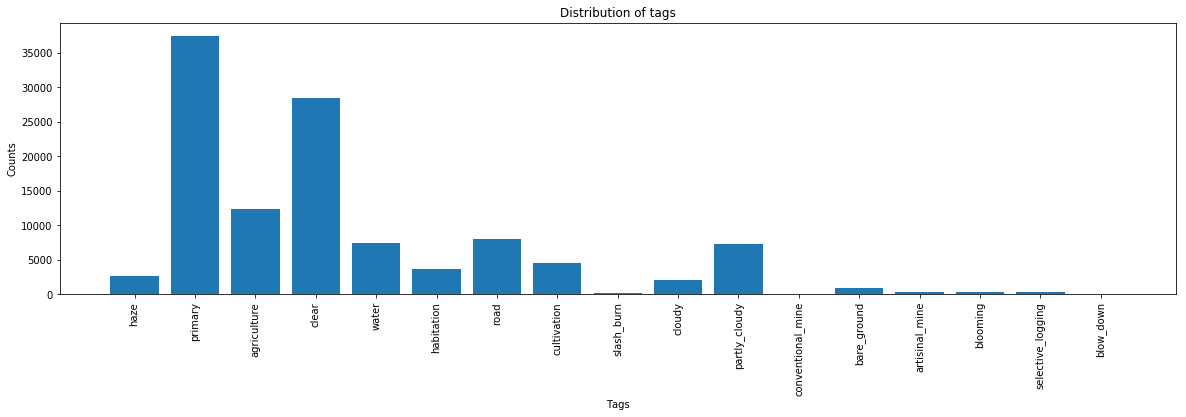

In [3]:
labels = df_train['tags'].apply(lambda x : x.split(' '))
counts = defaultdict(int)
for label in labels:
    for tag in label:
        counts[tag] += 1

x = list(counts.keys())
y = list(counts.values())
x_pos = [i for i,_ in enumerate(x)]
plt.figure(figsize=(20,5))
plt.bar(x_pos, y)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Distribution of tags')
plt.xticks(x_pos, x, rotation='vertical')
plt.show()

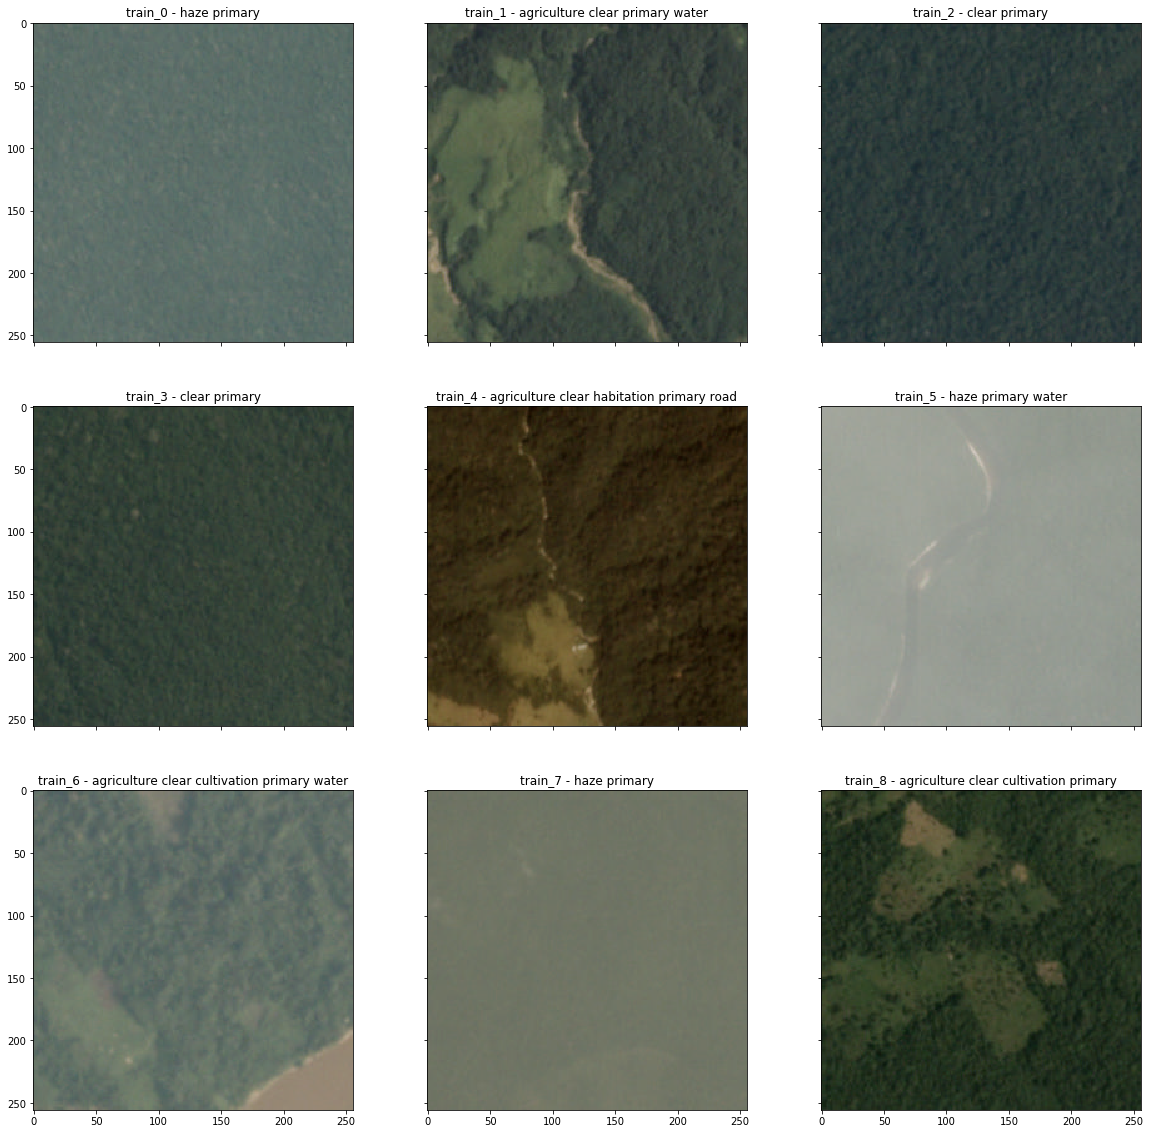

In [4]:
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    img = cv2.imread('../input/planet-understanding-the-amazon-from-space/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()

## Data Preparation

In [5]:
def _get_validation_split(df_train, validation_split_size):
    flatten = lambda l: [item for sublist in l for item in sublist]
    labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
    y_map = {l: i for i, l in enumerate(labels)}
    
    y_train = []
    
    for file_name, tags in df_train.values:
        targets = np.zeros(len(y_map))
        for t in tags.split(' '):
            targets[y_map[t]] = 1
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    
    train_index = []
    val_index = []
    index = np.arange(len(df_train))
    for i in range(len(y_map)):
        sss = StratifiedShuffleSplit(n_splits=2, test_size=validation_split_size, random_state=i)
        for train_idx, test_idx in sss.split(index, y_train[:,i]):
            X_train, X_test = index[train_idx], index[test_idx]
        train_index = train_index + list(set(X_train) - set(train_index) - set(val_index))
        val_index = val_index + list(set(X_test) - set(train_index) - set(val_index))
        
    return np.array(train_index), np.array(val_index)

In [6]:
def _get_class_mapping(data):
    file_path, tags, y_map = data
    targets = np.zeros(len(y_map))
    
    for t in tags.split(' '):
        targets[y_map[t]] = 1
        
    return file_path, targets

In [7]:
def _get_train_data_files(df_train, train_jpeg_dir, validation_split_size, process_count):
    train_files, train_tags = [], []
    val_files, val_tags = [], []
    x_train_files, y_train_files = [], []
    x_val_files, y_val_files = [], []
    
    files_path = []
    tags_list = []
    
    for file_name, tags in df_train.values:
        files_path.append('{}/{}.jpg'.format(train_jpeg_dir, file_name))
        tags_list.append(tags)
        
    train_index, val_index = _get_validation_split(df_train, validation_split_size)
    for index in train_index:
        train_files.append(files_path[index])
        train_tags.append(tags_list[index])
    for index in val_index:
        val_files.append(files_path[index])
        val_tags.append(tags_list[index])
    
    flatten = lambda l: [item for sublist in l for item in sublist]
    labels = list(set(flatten([tags.split(' ') for tags in df_train['tags'].values])))
    y_map = {l: i for i, l in enumerate(labels)}

    with ThreadPoolExecutor(process_count) as pool:
        for file_path, targets in tqdm(pool.map(_get_class_mapping, [(file_path, tags, y_map) for file_path, tags in zip(train_files, train_tags)]), total=len(train_files)):
            x_train_files.append(file_path)
            y_train_files.append(targets)
            
    with ThreadPoolExecutor(process_count) as pool:
        for file_path, targets in tqdm(pool.map(_get_class_mapping, [(file_path, tags, y_map) for file_path, tags in zip(val_files, val_tags)]), total=len(val_files)):
            x_val_files.append(file_path)
            y_val_files.append(targets)
            
    return [x_train_files, y_train_files, x_val_files, y_val_files, {v:k for k,v in y_map.items()}]

In [8]:
def _get_test_data_files(test_jpeg_dir):
    filenames = os.listdir(test_jpeg_dir)
    X_test_file_name = filenames
    X_test_file_path = [test_jpeg_dir+'/'+name for name in filenames]
    return X_test_file_name, X_test_file_path

In [9]:
def _val_transform_to_matrices(data):
    file_path, label = data
    image = Image.open(file_path)
    image.thumbnail((128,128))
    image = np.asarray(image.convert('RGB'), dtype=np.float32)
    image = image[:,:,::-1]
    image[:, :, 0] -= 103.939
    image[:, :, 1] -= 116.779
    image[:, :, 2] -= 123.68
    image = image / 255
    return image, label

In [10]:
def _preprocess_val_files(process_count, X_val, y_val):
    X = []
    y = []
    with ThreadPoolExecutor(process_count) as pool:
        for image, targets in pool.map(_val_transform_to_matrices, [(file_path, label) for file_path, label in zip(X_val, y_val)]):
            X.append(image)
            y.append(targets)
    result = [np.array(X), np.array(y)]
    print("Size consumed by validation matrices {} mb".format(result[0].nbytes/1024/1024))
    return result

In [11]:
def _get_train_generator(X_train, y_train, batch_size):
    augmentor = ImageDataGenerator(rescale=1./255,shear_range=0.2,horizontal_flip=True,vertical_flip=True)
    loop_range = len(X_train)
    
    while True:
        for i in range(loop_range):
            start_offset = batch_size * i
            range_offset = min(batch_size, loop_range-start_offset)
            
            if range_offset <= 0:
                break
                
            batch_features = np.zeros((range_offset, 128, 128, 3))
            batch_labels = np.zeros((range_offset, len(y_train[0])))
            
            for j in range(range_offset):
                image = Image.open(X_train[start_offset + j])
                image.thumbnail((128,128))
                image = np.asarray(image.convert('RGB'), dtype=np.float32)
                image = image[:,:,::-1]
                image[:, :, 0] -= 103.939
                image[:, :, 1] -= 116.779
                image[:, :, 2] -= 123.68
                
                batch_features[j] = image
                batch_labels[j] = y_train[start_offset + j]
                
            yield next(augmentor.flow(batch_features, batch_labels, range_offset))

In [12]:
def _get_prediction_generator(X_test_filename, batch_size):
    loop_range = len(X_test_filename)
    
    while True:
        for i in range(loop_range):
            start_offset = batch_size * i
            range_offset = min(batch_size, loop_range-start_offset)
            
            if range_offset <= 0:
                break
                
            batch_features = np.zeros((range_offset, 128, 128, 3))
            
            for j in range(range_offset):
                image = Image.open(X_test_filename[start_offset + j])
                image.thumbnail((128,128))
                image = np.asarray(image.convert('RGB'), dtype=np.float32)
                image = image[:,:,::-1]
                image[:, :, 0] -= 103.939
                image[:, :, 1] -= 116.779
                image[:, :, 2] -= 123.68
                image = image/255
    
                batch_features[j] = image
        
            yield batch_features

## Model

In [13]:
def create_model(shape):
    inputLayer = Input(shape)
    baseModel = VGG16(include_top=False, weights='imagenet', input_shape=shape)
    x = BatchNormalization()(inputLayer)
    x = baseModel(x)
    x = Flatten()(x)
    outputLayer = Dense(17, activation='sigmoid')(x)
    model = Model(inputLayer, outputLayer)
    return model

In [14]:
def predict(model, X_test_filename, X_test, batch_size=128):
    generator = _get_prediction_generator(X_test_filename, batch_size)
    predictions = model.predict_generator(generator=generator, verbose=1, steps=len(X_test_filename)/batch_size)
    assert len(X_test_filename) == len(predictions), "len(X_test_filename) = {}, len(predictions) = {}".format(len(X_test_filename), len(predictions))
    return np.array(X_test), predictions

In [15]:
def map_predictions(predictions, thresholds):
    predictions_labels = []
    for prediction in predictions:
        labels = [y_map[i] for i,value in enumerate(prediction) if value>thresholds[i]]
        predictions_labels.append(labels)
    return predictions_labels

In [16]:
def fbeta(model, X_valid, y_valid):
    p_valid = model.predict(X_valid)
    return fbeta_score(y_valid, np.array(p_valid)>0.2, beta=2, average='samples')

## Training

In [17]:
img_resize = (128,128)
validation_split_size = 0.2
train_jpeg_dir = '../input/planet-understanding-the-amazon-from-space/train-jpg'
test_jpeg_dir = '../input/planet-understanding-the-amazon-from-space/test-jpg-v2'
process_count = cpu_count()

In [18]:
X_train, y_train, X_val_pre, y_val_pre, y_map = _get_train_data_files(df_train, train_jpeg_dir, validation_split_size, process_count)

100%|██████████| 8096/8096 [00:00<00:00, 174913.90it/s]


In [19]:
X_val, y_val = _preprocess_val_files(process_count, X_val_pre, y_val_pre)

Size consumed by validation matrices 1518.0 mb


In [20]:
X_test, X_test_filename = _get_test_data_files(test_jpeg_dir)

In [26]:
model = create_model((128,128,3))
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


In [27]:
callbacks = [History(), 
             ModelCheckpoint(filepath='/kaggle/working/models/weights.best.hdf5', verbose=1, save_best_only=True, save_weights_only=True, mode='auto'),
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1)]

batch_size = 128
train_generator = _get_train_generator(X_train, y_train, batch_size)
steps = len(X_train) / batch_size

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator, steps, epochs=25, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/25
253/252 [==============================] - 213s 841ms/step - loss: 0.1383 - accuracy: 0.9458 - val_loss: 0.1240 - val_accuracy: 0.9527

Epoch 00001: val_loss improved from inf to 0.12400, saving model to /kaggle/working/models/weights.best.hdf5
Epoch 2/25
253/252 [==============================] - 206s 813ms/step - loss: 0.1031 - accuracy: 0.9608 - val_loss: 0.0961 - val_accuracy: 0.9636

Epoch 00002: val_loss improved from 0.12400 to 0.09613, saving model to /kaggle/working/models/weights.best.hdf5
Epoch 3/25
253/252 [==============================] - 206s 814ms/step - loss: 0.0955 - accuracy: 0.9634 - val_loss: 0.0938 - val_accuracy: 0.9643

Epoch 00003: val_loss improved from 0.09613 to 0.09378, saving model to /kaggle/working/models/weights.best.hdf5
Epoch 4/25
253/252 [==============================] - 204s 807ms/step - loss: 0.0912 - accuracy: 0.9651 - val_loss: 0.0920 - val_accuracy: 0.9648

Epoch 00004: val_loss improved from 0.09378 to 0.09202, saving model to /kagg

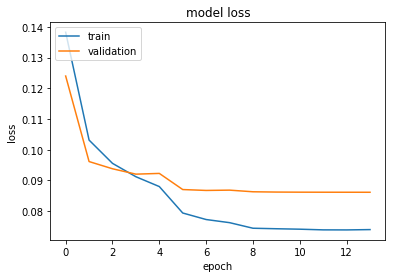

In [28]:
plt.plot(callbacks[0].history['loss'])
plt.plot(callbacks[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
model.load_weights("/kaggle/working/models/weights.best.hdf5")
print("Weights loaded")

Weights loaded


In [30]:
fbeta_score = fbeta(model, X_val, y_val)
fbeta_score

0.927704412082308

## Make Predictions

In [31]:
x_test_filename, predictions = predict(model, X_test_filename, X_test, batch_size=128)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              x_test_filename[0], predictions[0]))

479/478 [==============================] - 251s 524ms/step
Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions (test_36713.jpg) entry:
[9.36686993e-05 5.60489297e-03 9.96393263e-01 9.92474914e-01
 7.25209713e-04 1.01772398e-01 7.35193491e-04 1.17480755e-04
 1.60586804e-01 6.79096878e-02 9.99926329e-01 6.58810139e-03
 1.60366297e-04 8.00073147e-04 1.34110451e-06 2.04810798e-02
 6.93082809e-04]


In [34]:
predicted_labels = map_predictions(predictions=predictions, thresholds=[0.2]*len(counts))

In [38]:
predicted_tags = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    predicted_tags[i] = ' '.join(map(str, tags))
    
result = [[filename.split('.')[0], tags] for filename, tags in zip(x_test_filename, predicted_tags)]

In [43]:
df_result = pd.DataFrame(result, columns=['image_name', 'tags'])
df_result.head()

,image_name,tags
0,test_36713,clear water primary
1,file_20054,agriculture road primary partly_cloudy
2,file_19328,clear primary
3,test_26358,primary haze cloudy
4,test_25482,clear primary


In [47]:
df_result.to_csv('/kaggle/working/submission_file.csv', index=False)

In [48]:
os.chdir(r'/kaggle/working')

In [49]:
from IPython.display import FileLink
FileLink(r'submission_file.csv')

/kaggle/working/submission_file.csv